<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2022/blob/main/notebooks/es8/MetodiAI_Fis2022_Es8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CNNs: classificazione di immagini con una CNN di tipo VGG, uso di una rete pre-addesrata tramite tecniche di transfer learning 

### Informazioni ###

scopo: 
- familiarizzare con l'implementazione di CNN in pytorch
- imparare a come sfruttare modelli SOTA CNN preaddestrati su imagnet per task specifiche utilizzando la tecnica di transfer learning 

DL tool: pytorch

**Dataset:**

Sign Language Digits Dataset 
(Turkey Ankara Ayrancı Anadolu High School Students: [github-link](https://github.com/ardamavi/Sign-Language-Digits-Dataset))

Image size: 100 x 100 pixels 

Color space: RGB
Number of classes: 10 (Digits: 0-9)
Number of participant students: 218
Number of samples per student: 10

In [1]:
# download del dataset:
!rm -rf Dataset.zip
!rm -rf Dataset_test.zip
!rm -rf Dataset
!rm -rf Dataset_test
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
!unzip -q Dataset.zip
!unzip -q Dataset_test.zip
!rm -rf __MACOSX

--2022-07-02 14:39:38--  http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11254421 (11M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  10.73M  3.19MB/s    in 3.4s    

2022-07-02 14:39:42 (3.19 MB/s) - ‘Dataset.zip’ saved [11254421/11254421]

--2022-07-02 14:39:43--  http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5903386 (5.6M) [application/zip]
Saving to: ‘Dataset_test.zip’

Dataset_test.zip    100%[===================>]   5.63M  2.73MB/s    in 2.1s    

2022-07-02 14:39:45 (2.73

Nei folder Dataset e Dataset_test sono contenute le immagini, le immagini corrispondenti ai differenti numeri (0,1,2,3,4,5,6,7,9) sono inserite in sub-folders nominati in accordo al digit corrispondente ...

In [2]:
!ls Dataset/
!ls Dataset_test/
!ls Dataset/0/

0  1  2  3  4  5  6  7	8  9
0  1  2  3  4  5  6  7	8  9
IMG_1118.JPG  IMG_5028.JPG  IMG_5276.JPG  IMG_5527.JPG	IMG_5766.JPG
IMG_1128.JPG  IMG_5042.JPG  IMG_5286.JPG  IMG_5537.JPG	IMG_5776.JPG
IMG_1138.JPG  IMG_5053.JPG  IMG_5297.JPG  IMG_5547.JPG	IMG_5786.JPG
IMG_1148.JPG  IMG_5063.JPG  IMG_5308.JPG  IMG_5562.JPG	IMG_5796.JPG
IMG_1158.JPG  IMG_5074.JPG  IMG_5318.JPG  IMG_5572.JPG	IMG_5806.JPG
IMG_1169.JPG  IMG_5091.JPG  IMG_5328.JPG  IMG_5582.JPG	IMG_5816.JPG
IMG_1179.JPG  IMG_5101.JPG  IMG_5341.JPG  IMG_5592.JPG	IMG_5826.JPG
IMG_1189.JPG  IMG_5111.JPG  IMG_5350.JPG  IMG_5603.JPG	IMG_5837.JPG
IMG_1199.JPG  IMG_5122.JPG  IMG_5360.JPG  IMG_5615.JPG	IMG_5847.JPG
IMG_1209.JPG  IMG_5132.JPG  IMG_5370.JPG  IMG_5625.JPG	IMG_5857.JPG
IMG_1219.JPG  IMG_5142.JPG  IMG_5380.JPG  IMG_5635.JPG	IMG_5867.JPG
IMG_1229.JPG  IMG_5152.JPG  IMG_5390.JPG  IMG_5645.JPG	IMG_5877.JPG
IMG_1239.JPG  IMG_5163.JPG  IMG_5400.JPG  IMG_5655.JPG	IMG_5887.JPG
IMG_1249.JPG  IMG_5173.JPG  IMG_5412.JPG  IMG_5665.JPG	IMG_5

## Part 0: lettura del dataset, e preparazione dei dataloader pytorch

In [3]:
#import
import os.path
from torchsummary import summary

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

1.11.0+cu113
0.12.0+cu113


In [4]:
# lettura dei dati usando torchvision 

data_dir = 'Dataset'
test_dir = 'Dataset_test'

# definizione di un torchvision transform costituito da una composizione di trasformazioni utili 
# di processamento dei dati e data augmentation

train_transforms = transforms.Compose([#transforms.RandomRotation(10), #applica una rotazione random +/- 10 deg
                                       #transforms.RandomHorizontalFlip(), #applica un flip random dei pixel orizontal
                                       transforms.Resize((100,100)), #assicura che l'immagine sia 100x100
                                       transforms.ToTensor(), #converte in tensori torch
                                      ])

# la data augmentation è applicata solo alle immagini di training
test_transforms = test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                      ])


# trochvision.datasets mette a disposizione la funzione ImageFolder che permete di creare un dataset a partire da imagini 
# salvate in folder sul filesystem, automaticamente associa label alle immagini se queste sono salvate in 
# subfolders
# https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
testing_data = datasets.ImageFolder(test_dir, transform=test_transforms)

print(train_data)
print(testing_data)

# split test set in vali e test
test_data, vali_data = torch.utils.data.random_split(testing_data, [450, 455])

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders 

batch_size = 64
dataloaders = dict() #usiamo un dizionario epr comodità
dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloaders['vali'] = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Dataset ImageFolder
    Number of datapoints: 1157
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 905
    Root location: Dataset_test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Trainign set size:  1157
Validation set size:  455
Test set size:  450


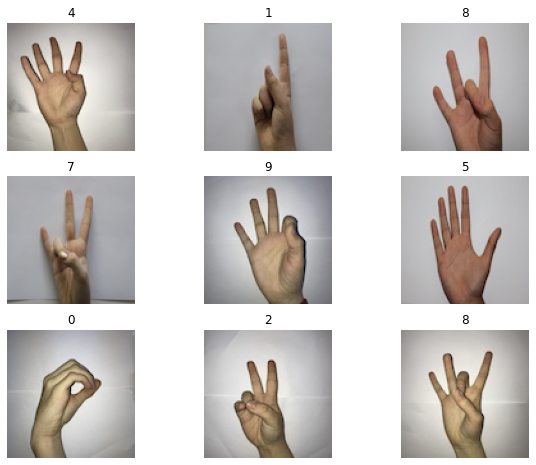

In [6]:
# plot di alcune delle immagini

figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) #nota: imshow si aspetta shape (h,w,channels)
plt.show()

In [7]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla P100-PCIE-16GB
Computation device: cuda



In [14]:
# Convolutional Neural Network (VGG-like architecture)

from torch import nn
import torch.nn.functional as F

class myVGG(nn.Module):
  def __init__(self):
    super(myVGG, self).__init__()

    # definizione dei layers

    # primo blocco convoluzionale
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3))
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

    # secondo blocco convoluzionale
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3))
    self.pool3 = nn.MaxPool2d(kernel_size=(2,2))

    # primo blocco convoluzionale
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))
    self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
    
    # MLP
    self.flatten = nn.Flatten() #flatten layer
    self.drop1 = nn.Dropout(p=0.5) #droput 
    self.fc1 = nn.Linear(in_features=3200, out_features=64)
    self.drop2 = nn.Dropout(p=0.5) #dropout 
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=10)

  # forward pass: x (input) -> out  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool3(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    #flatten
    x = self.flatten(x)

    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x))

    out = self.fc3(x)
    #out = F.log_softmax(x, dim=1)

    return out

In [15]:
# printout del modello

model = myVGG()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(3,100,100))
else:
  summary(model, input_size=(3,100,100))

myVGG(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3200, out_features=64, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 98, 98]             448
         MaxPool2d-2           [-1, 16, 49, 49]               0
            Conv2d-3           [-1, 16, 47, 47]   

In [16]:
# test di un batch sul modello non addestrato per vedere che le cose funzionino

feat, label = next(iter(dataloaders['train']))

feat=feat.to(device)
label=label.to(device)

out = model(feat)

print(out.shape)
print(out[0])

torch.Size([64, 10])
tensor([-0.0724, -0.0410, -0.1111,  0.0260, -0.0833, -0.0344, -0.1062,  0.0060,
         0.0894, -0.0873], device='cuda:0', grad_fn=<SelectBackward0>)


In [17]:
# loss function, accuracy, optimzer

# loss function 
loss_func = nn.CrossEntropyLoss() #cross entropy loss 
#loss_func = nn.NLLLoss()

# metric accuracy (in questo caso dobbiamo scrivercela da noi perché non è disponibile builtin in pytorch)
def accuracy(yhat, y):
    preds = torch.max(yhat,1)[1] #predizioni == neuroni con la massima probabilità
    batch_acc = (preds == y).sum()
    return batch_acc

metric_func = accuracy

# ottmizzatore: usiamo Adam
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

# aggiungiamo uno scheduler per il LR che diminusice il LR a intervalli fissati
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [18]:
# Checkpoints functions
# attraverso i checkpoints possiamo interagire con il modello durante il run-time
# Per esempio si puo' salvare il modello ad ogni epoca

#Checkpoint per salvare il modello durante il training (solo il best model)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pt')

In [19]:
# Training loop

model.to(device)
save_best_model = SaveBestModel()

import time

# numero di epoche
epochs = 40

# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()
    
    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0

    for xb, yb in dataloaders['train']:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device) #copio il mini batch di label sulla CPU/GPU

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        loss = loss_func(pred, yb)
        metric = metric_func(pred, yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    train_metric /= (counter*batch_size)
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che si aggiornino i pesi
      for xb, yb in dataloaders['vali']:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()  

    vali_loss /= counter
    vali_metric /= (counter*batch_size)
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))
    
    # update learning rate schedule
    scheduler.step()


Best validation loss: 2.301600754261017

Saving best model for epoch: 1

epoch: 1, time(s): 2.6718, train loss: 2.305373, train metric: 0.095395, vali loss: 2.301601, vali metric: 0.097656
Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 2, time(s): 2.9296, train loss: 2.303127, train metric: 0.096217, vali loss: 2.303095, vali metric: 0.097656
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 2.2849800288677216

Saving best model for epoch: 3

epoch: 3, time(s): 2.6571, train loss: 2.301501, train metric: 0.102796, vali loss: 2.284980, vali metric: 0.136719
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 2.1952255964279175

Saving best model for epoch: 4

epoch: 4, time(s): 2.6651, train loss: 2.270678, train metric: 0.161184, vali loss: 2.195226, vali metric: 0.314453
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 1.6207943111658096

Saving best model for epoch: 5

epoch: 5, time(s): 2.6469, train loss

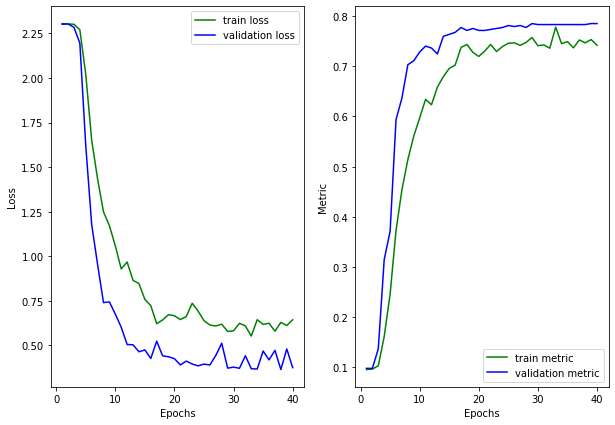

In [20]:
# grafico monitoring training
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [21]:
# test set perfromance

# lettura del modello
model_data = torch.load('./best_model.pt')
print('Best model at epoch: ', model_data['epoch'])
model = model_data['model']
model.eval() #va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model

# Non è strettamento necessario girare sulla GPU per l'inferenza (non richiede grande potenza di calcolo)
model.to(torch.device('cpu'))

loss = 0
metric = 0
counter = 0

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += accuracy(pred, yb).item()


loss /= counter
metric /= (counter*batch_size)

print('Test loss/accuracy: ',loss, ' / ', metric)

Best model at epoch:  38
Test loss/accuracy:  0.3691475810483098  /  0.779296875


In [22]:
#confusion matrix

#nice printout
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

predictions = np.empty(shape=(0,))
truths = np.empty(shape=(0,))
 
for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  res = torch.argmax(pred, dim=1)

  predictions = np.concatenate((predictions,res.detach().numpy()))
  truths = np.concatenate((truths,yb.detach().numpy()))

from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(predictions, truths, normalize='true')
print("Confusion Matrix:")
labels = ['0','1','2','3','4','5','6','7','8','9']
print_cm(c_mat, labels)        

Confusion Matrix:
              0     1     2     3     4     5     6     7     8     9 
        0  0.88  0.00  0.02  0.00  0.04  0.00  0.00  0.02  0.00  0.04 
        1  0.00  0.92  0.05  0.00  0.00  0.00  0.00  0.03  0.00  0.00 
        2  0.00  0.00  0.92  0.02  0.00  0.00  0.02  0.04  0.00  0.00 
        3  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
        4  0.00  0.00  0.00  0.00  0.77  0.00  0.06  0.12  0.06  0.00 
        5  0.00  0.00  0.00  0.00  0.00  0.96  0.00  0.00  0.00  0.04 
        6  0.00  0.00  0.00  0.00  0.03  0.00  0.93  0.03  0.03  0.00 
        7  0.00  0.00  0.04  0.00  0.02  0.00  0.02  0.83  0.08  0.02 
        8  0.00  0.00  0.00  0.00  0.08  0.00  0.05  0.00  0.84  0.03 
        9  0.00  0.00  0.00  0.02  0.02  0.05  0.00  0.02  0.02  0.85 


### Risolviamo la task di classificazione utilizzando una rete CNN preaddestrata su un grande dataset (imagent) e applicando transfer learning:


1.   si definisce e carical il modello preaddestrato da pytroch
2.   si modifica l'MLP per il nostro scopo
3.   si si congelano i pesi dei blocchi convoluzionali e si addestra l'MLP
4.   si rilasciano i pesi e si fa un fine tuning di poche eopoche con un learning rate molto piccolo



In [23]:
# carichiamo uno dei modelli preaddestrati da torchvision
from torchvision import datasets, transforms, models

# esempio densenet121
model = models.densenet121(pretrained= True)

print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [24]:
# congelo i parametri del modello

for param in model.parameters():
    param.requires_grad = False

# aggiungo l'MLP per la classificazione

# una versione più sofisiticata dei dizionari di python che permette di ricordare l'ordine 
# in cui gli elementi sono stati aggiunti al dizionario
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('dropout1',nn.Dropout(0.5)),
    # define the inputs must be 1024 for densent121 model
    ('fc1',nn.Linear(1024,64)),
    ('relu1', nn.ReLU()),
    ('dropout2',nn.Dropout(0.5)),
    ('fc2',nn.Linear(64,64)),
    ('relu2', nn.ReLU()),
    ('output',nn.Linear(64,10)),
    #('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [25]:
# loss e ottmizzatore

loss_func = nn.CrossEntropyLoss() #cross entropy loss 
# loss_func = nn.NLLLoss()

# metric accuracy (in questo caso dobbiamo scrivercela da noi perché non è disponibile builtin in pytorch)
def accuracy(yhat, y):
    preds = torch.max(yhat,1)[1] #predizioni == neuroni con la massima probabilità
    batch_acc = (preds == y).sum()
    return batch_acc

metric_func = accuracy

# ottmizzatore: usiamo Adam
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

In [26]:
# dati: densenet121 richiede immagini in input didimensione 224x224 (è stato addestrato con immagini 
# di imagnet di quella dimensione, dobbiamo fare un resize delle immagini del nostro campione)

# lettura dei dati usando torchvision 

data_dir = 'Dataset'
test_dir = 'Dataset_test'

# definizione di un torchvision transform costituito da una composizione di trasformazioni utili 
# di processamento dei dati e data augmentation

train_transforms = transforms.Compose([#transforms.RandomRotation(10), #applica una rotazione random +/- 10 deg
                                       #transforms.RandomHorizontalFlip(), #applica un flip random dei pixel orizontal
                                       transforms.Resize((224,224)), #assicura che l'immagine sia 224,224
                                       transforms.ToTensor(), #converte in tensori torch
                                      ])

# la data augmentation è applicata solo alle immagini di training
test_transforms = test_transforms = transforms.Compose([
                                       transforms.Resize((224,224)), 
                                       transforms.ToTensor(),
                                      ])


# trochvision.datasets mette a disposizione la funzione ImageFolder che permete di creare un dataset a partire da imagini 
# salvate in folder sul filesystem, automaticamente associa label alle immagini se queste sono salvate in 
# subfolders
# https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
testing_data = datasets.ImageFolder(test_dir, transform=test_transforms)

print(train_data)
print(testing_data)

# split test set in vali e test
test_data, vali_data = torch.utils.data.random_split(testing_data, [450, 455])

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders 

batch_size = 64
dataloaders = dict() #usiamo un dizionario epr comodità
dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloaders['vali'] = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


Dataset ImageFolder
    Number of datapoints: 1157
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 905
    Root location: Dataset_test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Trainign set size:  1157
Validation set size:  455
Test set size:  450


In [27]:
# Training loop

model.to(device)

import time

# numero di epoche
epochs = 20

# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()
    
    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0

    for xb, yb in dataloaders['train']:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device) #copio il mini batch di label sulla CPU/GPU

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        loss = loss_func(pred, yb)
        metric = metric_func(pred, yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    train_metric /= (counter*batch_size)
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che si aggiornino i pesi
      for xb, yb in dataloaders['vali']:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()  

    vali_loss /= counter
    vali_metric /= (counter*batch_size)
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))


epoch: 1, time(s): 6.9575, train loss: 2.299954, train metric: 0.113487, vali loss: 2.268483, vali metric: 0.269531
epoch: 2, time(s): 8.2234, train loss: 2.229351, train metric: 0.189145, vali loss: 2.132566, vali metric: 0.267578
epoch: 3, time(s): 6.9497, train loss: 2.109391, train metric: 0.243421, vali loss: 1.954264, vali metric: 0.382812
epoch: 4, time(s): 6.8988, train loss: 1.931674, train metric: 0.313322, vali loss: 1.617781, vali metric: 0.412109
epoch: 5, time(s): 6.8923, train loss: 1.750196, train metric: 0.354441, vali loss: 1.434904, vali metric: 0.539062
epoch: 6, time(s): 6.9239, train loss: 1.641486, train metric: 0.387336, vali loss: 1.248413, vali metric: 0.595703
epoch: 7, time(s): 6.9384, train loss: 1.481874, train metric: 0.435033, vali loss: 1.129103, vali metric: 0.626953
epoch: 8, time(s): 6.9277, train loss: 1.423016, train metric: 0.467928, vali loss: 0.996340, vali metric: 0.630859
epoch: 9, time(s): 6.9200, train loss: 1.455613, train metric: 0.463816,

In [28]:
torch.save(model, './densenet121_model.pt')

In [29]:
# fine tuning: unfrize all the weights, set lr to a very small number like 1e04 or 1e-5 and train for few epochs

for param in model.parameters():
    param.requires_grad = True

LR_ST = 1e-5
opt = optim.Adam(model.parameters(), lr=LR_ST)

# Training loop
import time

# numero di epoche
epochs = 10

# liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione 
# dell'epoca a fine addestramento
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

# loop sulle epoche
for epoch in range(epochs):
    t0 = time.time()
    
    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0

    for xb, yb in dataloaders['train']:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device) #copio il mini batch di label sulla CPU/GPU

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        loss = loss_func(pred, yb)
        metric = metric_func(pred, yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    train_metric /= (counter*batch_size)
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che si aggiornino i pesi
      for xb, yb in dataloaders['vali']:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = model(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()  

    vali_loss /= counter
    vali_metric /= (counter*batch_size)
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

epoch: 1, time(s): 11.4156, train loss: 0.990177, train metric: 0.612664, vali loss: 0.644606, vali metric: 0.750000
epoch: 2, time(s): 11.4042, train loss: 0.894907, train metric: 0.695724, vali loss: 0.505757, vali metric: 0.785156
epoch: 3, time(s): 11.4304, train loss: 0.836603, train metric: 0.689145, vali loss: 0.453925, vali metric: 0.791016
epoch: 4, time(s): 11.3735, train loss: 0.796080, train metric: 0.737664, vali loss: 0.450837, vali metric: 0.789062
epoch: 5, time(s): 11.3835, train loss: 0.715173, train metric: 0.734375, vali loss: 0.389626, vali metric: 0.800781
epoch: 6, time(s): 11.3665, train loss: 0.625152, train metric: 0.747533, vali loss: 0.413792, vali metric: 0.824219
epoch: 7, time(s): 11.6181, train loss: 0.608498, train metric: 0.772204, vali loss: 0.336483, vali metric: 0.814453
epoch: 8, time(s): 11.8919, train loss: 0.589492, train metric: 0.773849, vali loss: 0.317536, vali metric: 0.824219
epoch: 9, time(s): 12.6160, train loss: 0.543488, train metric: 

In [30]:
torch.save(model, './densenet121_model.pt')

In [31]:
# prestazioni sul campione di test
model = torch.load('./densenet121_model.pt')
model.eval() 

loss_func = nn.CrossEntropyLoss() #cross entropy loss 

# metric accuracy (in questo caso dobbiamo scrivercela da noi perché non è disponibile builtin in pytorch)
def accuracy(yhat, y):
    preds = torch.max(yhat,1)[1] #predizioni == neuroni con la massima probabilità
    batch_acc = (preds == y).sum()
    return batch_acc

metric_func = accuracy


model.to(device)

loss = 0
metric = 0
counter = 0

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to(device)
  yb=yb.to(device)
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += accuracy(pred, yb).item()


loss /= counter
metric /= (counter*16)

print('Test loss/accuracy: ',loss, ' / ', metric)

Test loss/accuracy:  0.3092259408520727  /  0.9202586206896551
